Sarcasm Detection

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import src.data_processing as data_processing 
import src.utils as utils

from collections import Counter
from wordcloud import WordCloud

from sklearn.metrics import classification_report,confusion_matrix

import joblib
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer,ENGLISH_STOP_WORDS
import torch
from sklearn.manifold import TSNE

This notebook only presents the visualization part of our project.  
You can find all the code, report, and slides at the following link:  

[GitHub Repository](https://github.com/Lynchrocket/Sarcasm-Detection_HoNLP.git)

In [ ]:
import webbrowser
# GitHub link
github_url = "https://github.com/Lynchrocket/Sarcasm-Detection_HoNLP.git"
webbrowser.open(github_url)

True

In [ ]:
train_cleaned, train_labels, test_cleaned, test_labels = data_processing.get_clean_data(
    "data/datasets/ghosh/train_sample.txt",
    "data/datasets/ghosh/test_sample.txt"
)

In [66]:
with open("processed_data/train_tweets_clean.txt", "r", encoding="utf-8") as f:
    train_lines = f.read().splitlines()

with open("processed_data/test_tweets_clean.txt", "r", encoding="utf-8") as f:
    test_lines = f.read().splitlines()

train_cleaned_df = pd.DataFrame(train_lines, columns=["Text"])
test_cleaned_df = pd.DataFrame(test_lines, columns=["Text"])

Data Balancing

In [39]:
train_df = pd.DataFrame({
    'Text': train_cleaned,
    'Label': train_labels
})

test_df = pd.DataFrame({
    "Text": test_cleaned,
    "Label": test_labels
})

In [75]:
def plot_pie_chart(labels, title):
    label_counts = [sum(labels == 0), sum(labels == 1)]
    label_names = ['Non-Sarcastic', 'Sarcastic']

    colors = ['#66b3ff', '#ff9999']  
    plt.figure(figsize=(8, 8), facecolor='white') 
    
    wedges, texts, autotexts = plt.pie(
        label_counts,
        labels=label_names,
        colors=colors,
        autopct='%1.1f%%',
        startangle=90,
        textprops={'fontsize': 12, 'color': 'black'},  
    )
    
    plt.title(title, fontsize=15, pad=20)
    plt.axis('equal')  
    
    for autotext in autotexts:
        autotext.set_fontsize(12)
        autotext.set_color('white')  
    
    plt.tight_layout()  
    plt.show()

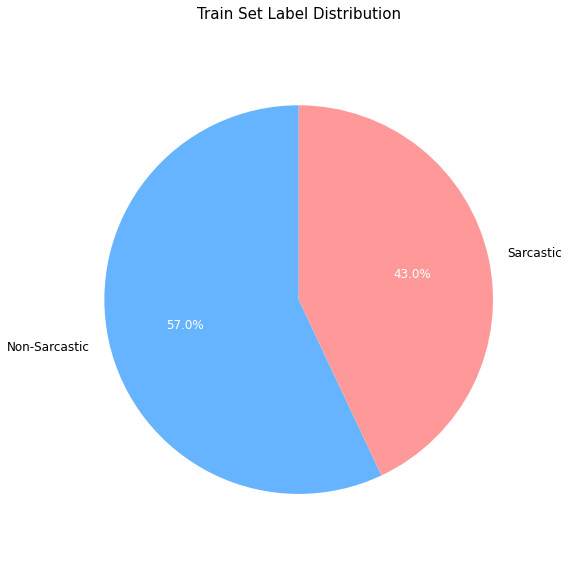

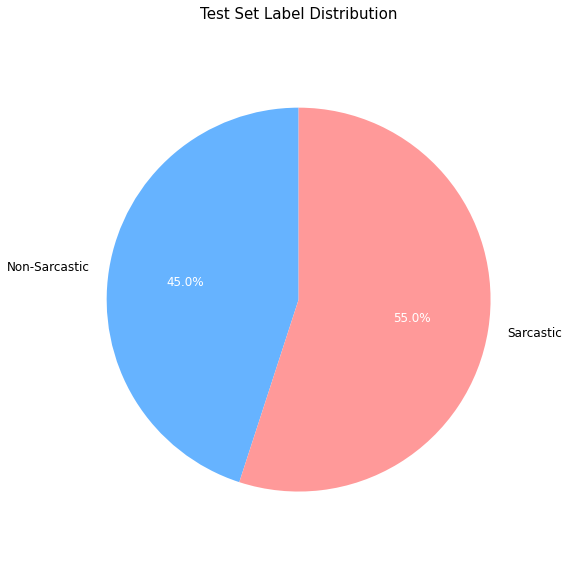

In [76]:
plot_pie_chart(train_df['Label'], 'Train Set Label Distribution')
plot_pie_chart(test_df['Label'], 'Test Set Label Distribution')

Show 20 High Frequency Words With Stop Words

In [40]:
sarcastic_df = train_df[train_df['Label'] == 1]
non_sarcastic_df = train_df[train_df['Label'] == 0]

In [78]:
def get_word_counts(df):
    words = df['Text'].apply(lambda x: x.split()).explode().tolist()
    word_counts = Counter(words).most_common(20)
    return word_counts

In [72]:

def get_all_counts(df):
    words = df['Text'].apply(lambda x: x.split()).explode().tolist()
    total_words = len(words)
    return total_words

In [13]:
def plot_bar_chart_with_median(word_counts, label_type):
    plt.figure(figsize=(12, 8))
    
    words, counts = zip(*word_counts)
    
    cmap = plt.cm.get_cmap('coolwarm', len(counts))  
    norm = plt.Normalize(vmin=min(counts), vmax=max(counts))  

    bars = plt.barh(words, counts, color=cmap(norm(counts)), edgecolor='black', height=0.8, zorder=3)
    
    median_value = np.median(counts)
    
    plt.axvline(median_value, color='red', linestyle='--', linewidth=2, label=f'Median: {median_value}')
    
    plt.gca().invert_yaxis()
    plt.title(f'Top 20 {label_type} Words',fontsize=18)
    plt.xlabel('Frequency',fontsize=14)
    plt.ylabel('Words',fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.legend(loc='upper right', fontsize=12, facecolor='white')
    plt.tight_layout()
    plt.show()

In [14]:
def plot_word_cloud(word_counts, label_type):
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white'
    ).generate_from_frequencies(dict(word_counts))
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(f'{label_type} Word Cloud')
    plt.show()

In [75]:
sarcastic_word_counts_all = get_all_counts(sarcastic_df)
non_sarcastic_word_counts_all = get_all_counts(non_sarcastic_df)
sarcastic_word_counts_all
non_sarcastic_word_counts_all

970

C:\Users\18052\AppData\Local\Temp\ipykernel_8788\162409676.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('coolwarm', len(counts))


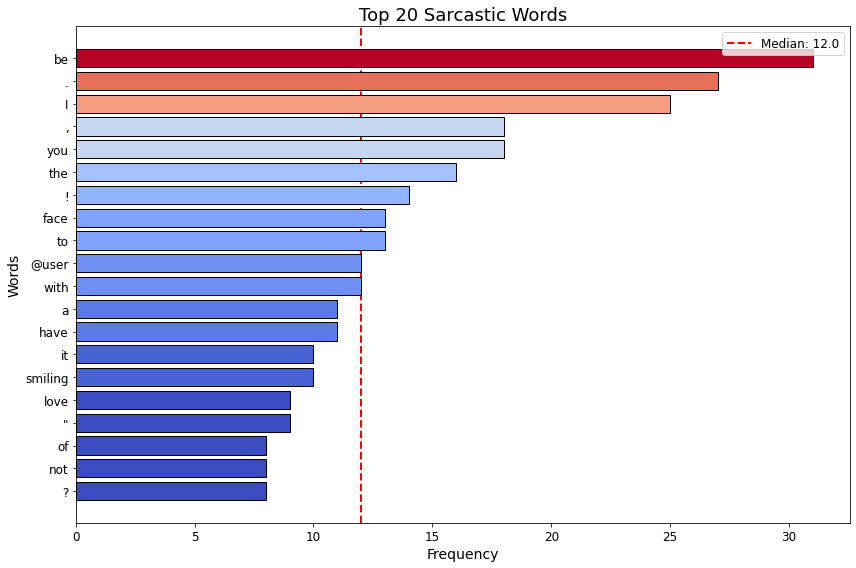

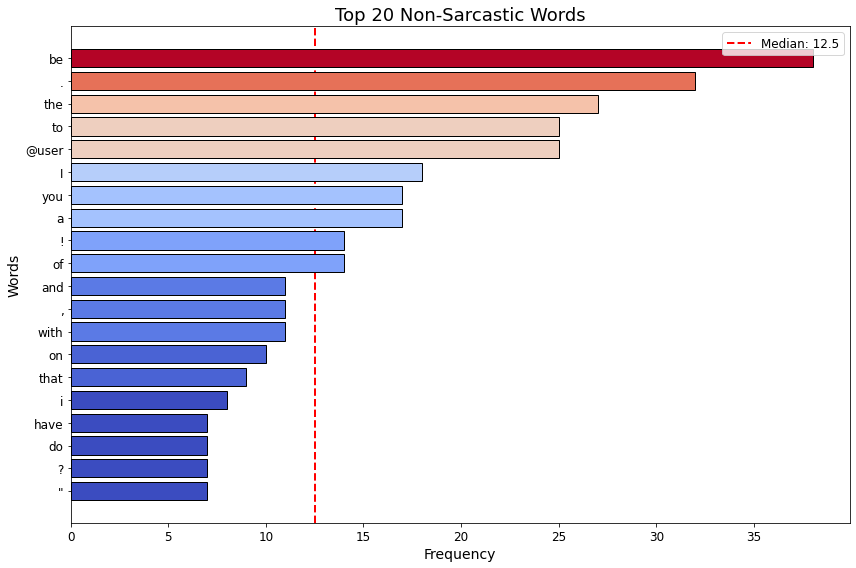

In [81]:
sarcastic_word_counts = get_word_counts(sarcastic_df)
non_sarcastic_word_counts = get_word_counts(non_sarcastic_df)

plot_bar_chart_with_median(sarcastic_word_counts, 'Sarcastic') 
plot_bar_chart_with_median(non_sarcastic_word_counts, 'Non-Sarcastic')  

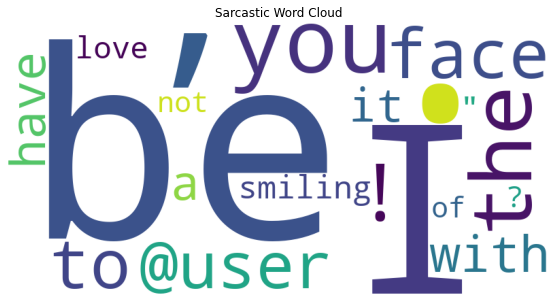

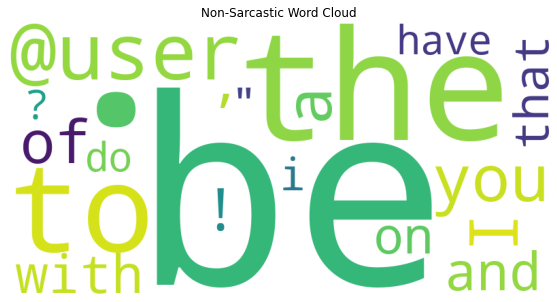

In [82]:
plot_word_cloud(sarcastic_word_counts, 'Sarcastic')
plot_word_cloud(non_sarcastic_word_counts, 'Non-Sarcastic')

In [15]:
def plot_combined_word_cloud(sarcastic_word_counts, non_sarcastic_word_counts):
    sarcastic_wc = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='Reds',  
        max_words=100
    ).generate_from_frequencies(dict(sarcastic_word_counts))

    non_sarcastic_wc = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='Blues',  
        max_words=100
    ).generate_from_frequencies(dict(non_sarcastic_word_counts))

    plt.figure(figsize=(15, 8))

    plt.subplot(1, 2, 1)
    plt.imshow(sarcastic_wc, interpolation='bilinear')
    plt.axis('off')
    plt.title('Sarcastic Word Cloud', fontsize=16)

    plt.subplot(1, 2, 2)
    plt.imshow(non_sarcastic_wc, interpolation='bilinear')
    plt.axis('off')
    plt.title('Non-Sarcastic Word Cloud', fontsize=16)

    plt.tight_layout()
    plt.show()

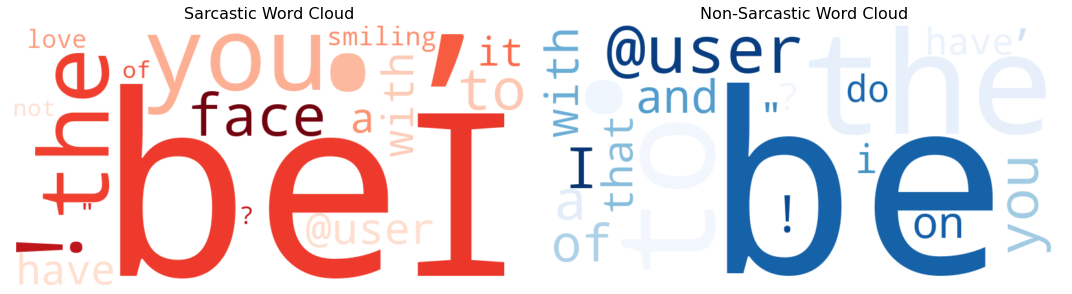

In [84]:
plot_combined_word_cloud(sarcastic_word_counts, non_sarcastic_word_counts)

Show 20 High Frequency Words Without Stop Words

In [ ]:
def get_word_counts_no_stopwords(df):
    custom_stopwords = list(ENGLISH_STOP_WORDS) + ["user"]
    vectorizer = CountVectorizer(stop_words=custom_stopwords)
    count_matrix = vectorizer.fit_transform(df['Text'])
    word_counts = np.asarray(count_matrix.sum(axis=0)).flatten()
    words = vectorizer.get_feature_names_out()
    top_words = sorted(zip(words, word_counts), key=lambda x: -x[1])[:20]
    return top_words

C:\Users\18052\AppData\Local\Temp\ipykernel_20524\162409676.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('coolwarm', len(counts))


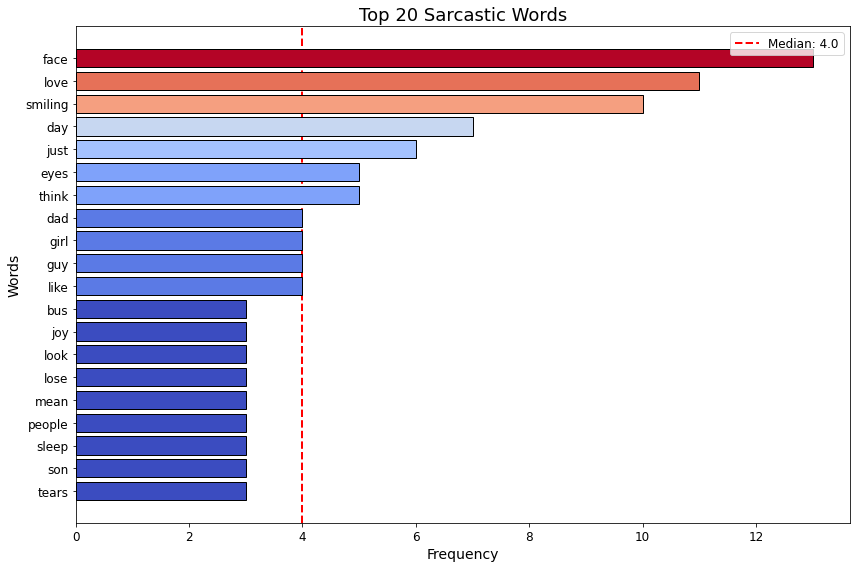

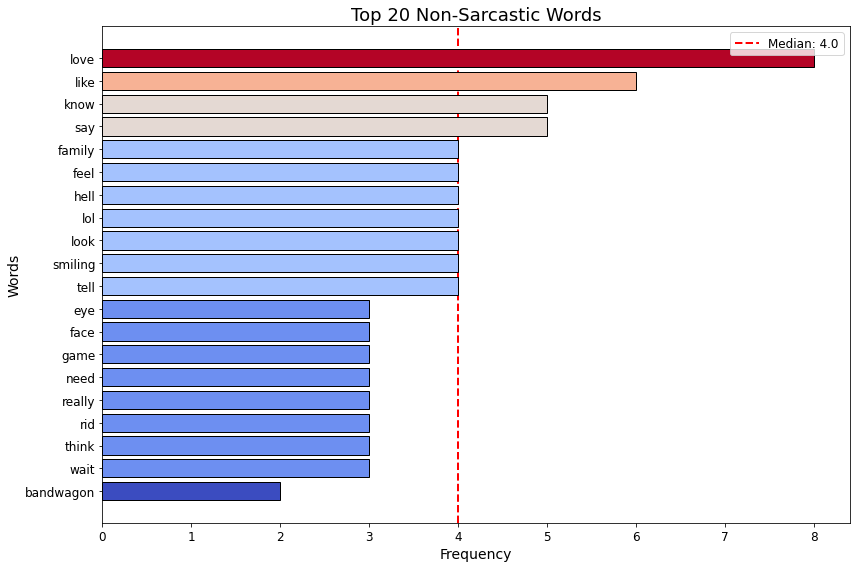

In [56]:
sarcastic_word_counts_no_stopwords= get_word_counts_no_stopwords(sarcastic_df)
non_sarcastic_word_counts_no_stopwords = get_word_counts_no_stopwords(non_sarcastic_df)

plot_bar_chart_with_median(sarcastic_word_counts_no_stopwords, 'Sarcastic') 
plot_bar_chart_with_median(non_sarcastic_word_counts_no_stopwords, 'Non-Sarcastic')  

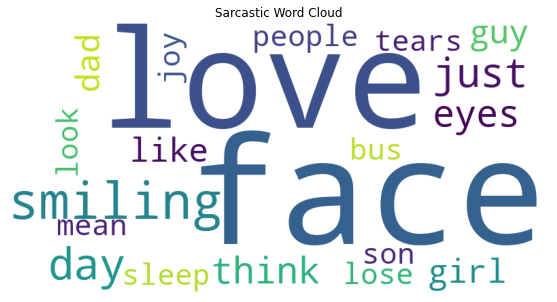

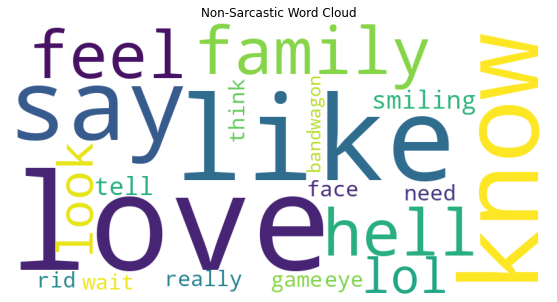

In [53]:
plot_word_cloud(sarcastic_word_counts_no_stopwords, 'Sarcastic')
plot_word_cloud(non_sarcastic_word_counts_no_stopwords, 'Non-Sarcastic')

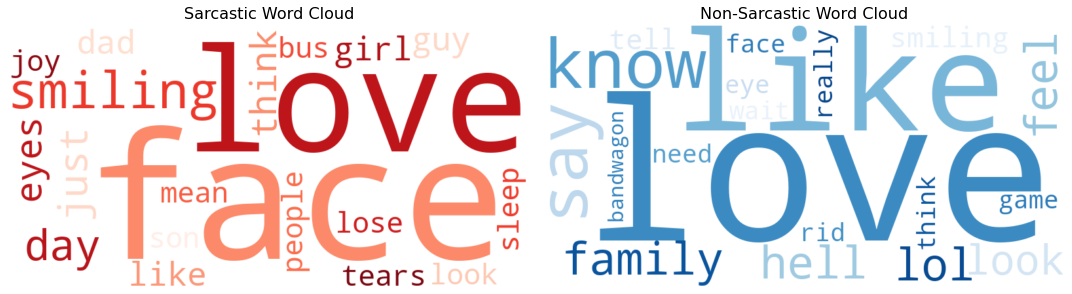

In [54]:
plot_combined_word_cloud(sarcastic_word_counts_no_stopwords, non_sarcastic_word_counts_no_stopwords)

 Vectorization and model training:

In [67]:
train_sentences = train_cleaned_df["Text"].apply(lambda x: x.split()).tolist()
test_sentences = test_cleaned_df["Text"].apply(lambda x: x.split()).tolist()

SVM model with TD-IDF

In [ ]:
svm_model_file = './model/model_svm.pkl'
svm_model = joblib.load(svm_model_file)

vectorizer = TfidfVectorizer(max_features=1000)
train_x_svm = vectorizer.fit_transform(train_lines).toarray()
test_x_svm = vectorizer.transform(test_lines).toarray()

Deep Learning Model with Skip-gram and fasttext

In [70]:
word2vec_skipgram, word2int = utils.get_word2vec_model(train_sentences, model_type='skipgram')

In [71]:
word2vec, word2int = utils.get_word2vec_model(train_sentences, model_type='fasttext')

Exception in thread Thread-143:
Traceback (most recent call last):
  File "c:\Users\18052\anaconda3\lib\threading.py", line 973, in _bootstrap_inner
    self.run()
  File "c:\Users\18052\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\18052\anaconda3\lib\threading.py", line 910, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\18052\anaconda3\lib\subprocess.py", line 1479, in _readerthread
    buffer.append(fh.read())
  File "c:\Users\18052\anaconda3\lib\codecs.py", line 322, in decode
    (result, consumed) = self._buffer_decode(data, self.errors, final)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xc8 in position 24: invalid continuation byte
c:\Users\18052\anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
'NoneType' object has no attribute 'splitlines'
Returning the number

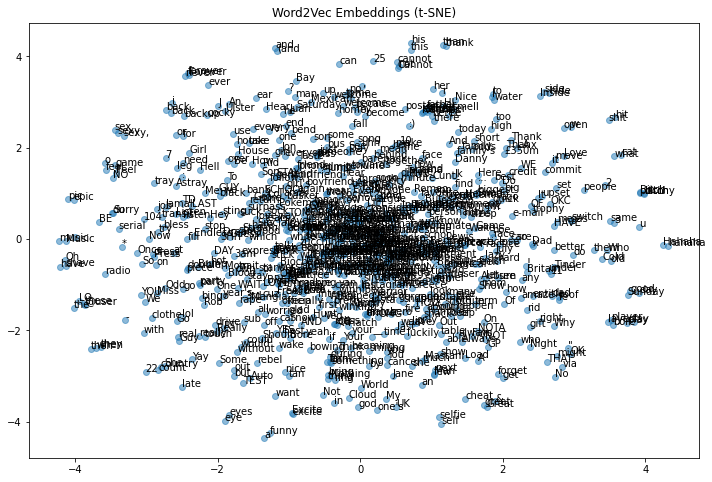

In [ ]:
words = [word for word in list(word2int.keys())[:1000] if word in word2vec.wv]

vectors = np.array([word2vec.wv[word] for word in words])  # transfer into (n_samples, n_features)

tsne = TSNE(n_components=2, random_state=42)
vectors_2d = tsne.fit_transform(vectors)

plt.figure(figsize=(12, 8))
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], alpha=0.5)
for i, word in enumerate(words):
    plt.annotate(word, (vectors_2d[i, 0], vectors_2d[i, 1]))
plt.title("Word2Vec Embeddings (t-SNE)")
plt.show()

In [90]:
def load_model(file_path):
    model = torch.load(file_path, map_location=torch.device('cpu'), weights_only=False)
    model.eval()
    return model

In [91]:
def text_to_sequence(text, word2int, max_len):
    tokens = text.split()
    seq = [word2int.get(token, 0) for token in tokens]
    seq = seq[:max_len] if len(seq) > max_len else seq + [0] * (max_len - len(seq))
    return seq

In [92]:
max_len = utils.get_max_len(train_cleaned)

In [93]:
test_sequences = [text_to_sequence(text, word2int, max_len) for text in test_lines]
X_test_tensor = torch.tensor(test_sequences, dtype=torch.long)

In [ ]:
model_paths = {
    "LSTM-FastText": "./model/model_lstm_fasttext_50.pth",
    "LSTM-SkipGram": "./model/model_lstm_skipgram_50.pth",
    "CNN-SkipGram": "./model/model_cnn_skipgram_50.pth",
    "CNN-FastText": "./model/model_cnn_fasttext_50.pth"
}

Prediction:

In [95]:
def predict(model, X_test_tensor):
    with torch.no_grad():
        outputs = model(X_test_tensor)
        return (outputs.squeeze() > 0.5).int().numpy()

In [104]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Sarcasm", "Sarcasm"], 
                yticklabels=["Non-Sarcasm", "Sarcasm"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

In [ ]:
def show_classification_report(y_true, y_pred):
    print(classification_report(y_true, y_pred, target_names=["Non-Sarcastic", "Sarcastic"]))

In [102]:
# prediction SVM
svm_preds = svm_model.predict(test_x_svm)

#prediction deep learning
y_preds = {}
for model_name, file_path in model_paths.items():
    model = load_model(file_path)
    y_preds[model_name] = predict(model, X_test_tensor)

y_true = np.array(test_labels)  

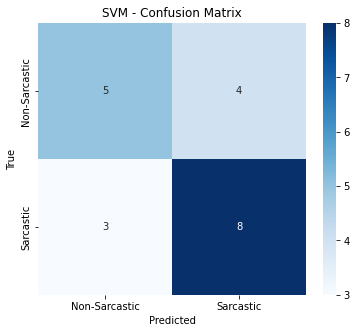

SVM - Classification Report:
               precision    recall  f1-score   support

Non-Sarcastic       0.62      0.56      0.59         9
    Sarcastic       0.67      0.73      0.70        11

     accuracy                           0.65        20
    macro avg       0.65      0.64      0.64        20
 weighted avg       0.65      0.65      0.65        20



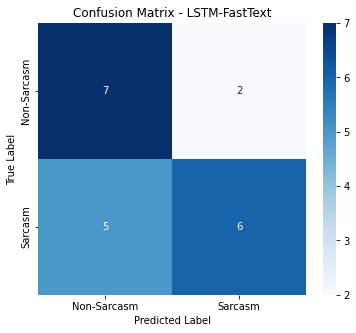


Classification Report for LSTM-FastText:
              precision    recall  f1-score   support

           0       0.58      0.78      0.67         9
           1       0.75      0.55      0.63        11

    accuracy                           0.65        20
   macro avg       0.67      0.66      0.65        20
weighted avg       0.68      0.65      0.65        20



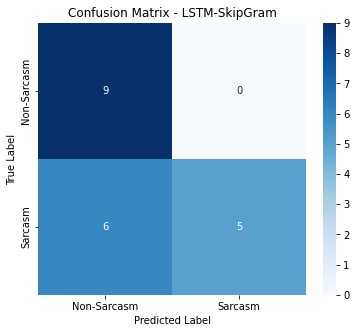


Classification Report for LSTM-SkipGram:
              precision    recall  f1-score   support

           0       0.60      1.00      0.75         9
           1       1.00      0.45      0.62        11

    accuracy                           0.70        20
   macro avg       0.80      0.73      0.69        20
weighted avg       0.82      0.70      0.68        20



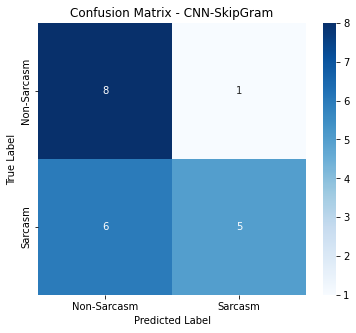


Classification Report for CNN-SkipGram:
              precision    recall  f1-score   support

           0       0.57      0.89      0.70         9
           1       0.83      0.45      0.59        11

    accuracy                           0.65        20
   macro avg       0.70      0.67      0.64        20
weighted avg       0.72      0.65      0.64        20



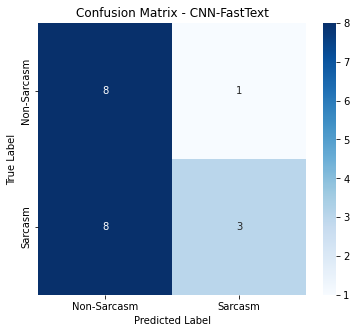


Classification Report for CNN-FastText:
              precision    recall  f1-score   support

           0       0.50      0.89      0.64         9
           1       0.75      0.27      0.40        11

    accuracy                           0.55        20
   macro avg       0.62      0.58      0.52        20
weighted avg       0.64      0.55      0.51        20



In [105]:
cm_svm = confusion_matrix(test_labels, svm_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Non-Sarcastic", "Sarcastic"],
            yticklabels=["Non-Sarcastic", "Sarcastic"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("SVM - Confusion Matrix")
plt.show()

print("SVM - Classification Report:")
print(classification_report(test_labels, svm_preds, target_names=["Non-Sarcastic", "Sarcastic"]))

for model_name, y_pred in y_preds.items():
    plot_confusion_matrix(y_true, y_pred, title=f"Confusion Matrix - {model_name}")
    print(f"\nClassification Report for {model_name}:")
    show_classification_report(y_true, y_pred)

Comparison with Reference Paper

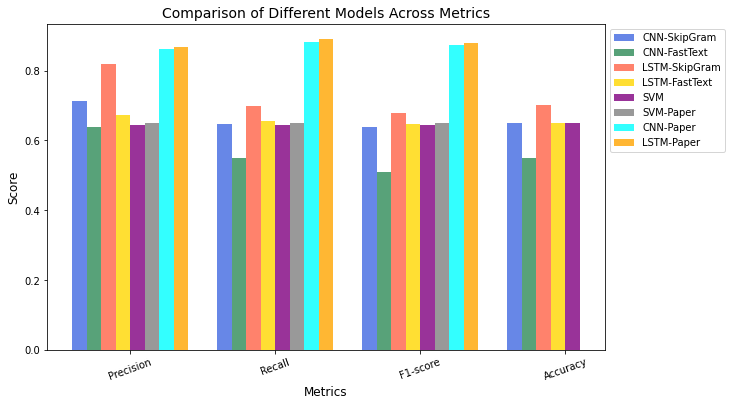

In [ ]:
model_names_C = [
    "CNN-SkipGram", "CNN-FastText", "LSTM-SkipGram", "LSTM-FastText",
    "SVM", "SVM-Paper", "CNN-Paper", "LSTM-Paper"
]


precision_values = [0.713, 0.638, 0.820, 0.674, 0.645, 0.65, 0.861, 0.868]
recall_values = [0.648, 0.549, 0.698, 0.654, 0.645, 0.65, 0.882, 0.89]
f1_values = [0.6395, 0.508, 0.6785, 0.648, 0.645, 0.65, 0.872, 0.879]
accuracy_values = [0.65, 0.55, 0.70, 0.65, 0.65, np.nan, np.nan, np.nan]

metrics = ["Precision", "Recall", "F1-score", "Accuracy"]
data_matrix = np.array([precision_values, recall_values, f1_values, accuracy_values]).T

x = np.arange(len(metrics))  
width = 0.1

colors = [
    "royalblue", "seagreen", "tomato", "gold",
    "purple", "gray", "cyan", "orange"
]

fig, ax = plt.subplots(figsize=(10, 6))

bars = []  
for i, (model, color) in enumerate(zip(model_names_C, colors)):
    values = data_matrix[i]
    bars.append(ax.bar(x + i * width, values, width, label=model, color=color, alpha=0.8))

ax.set_xlabel("Metrics", fontsize=12)
ax.set_ylabel("Score", fontsize=12)
ax.set_title("Comparison of Different Models Across Metrics", fontsize=14)
ax.set_xticks(x + (len(model_names_C) * width) / 2 - width / 2)
ax.set_xticklabels(metrics, fontsize=10)
ax.legend(bars, model_names_C, loc="upper left", bbox_to_anchor=(1, 1))

plt.xticks(rotation=20)
plt.show()